## 직접 이미지 제너레이터를 구성하여 이미지 분류기 반들기

In [1]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)

data_path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
data_path

68608000/68606236 [==============================] - 0s 0us/step


'/root/.keras/datasets/cats_and_dogs_filtered'

In [6]:
!find $data_path -type d

/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [9]:
train_dir = os.path.join(data_path, 'train')
validation_dir = os.path.join(data_path, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_cats_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print('--')
print('total training images:', total_train)
print('total validation images:', total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
total training images: 2000
total validation images: 1000


- 데이터를 디스크에서 읽는다.
- 이미지를 텐서로 변환.
- Rescale/ normalize 과정

=> ImageDataGenerator

In [11]:
bs = 128
epochs = 5
IMG_HEIGHT = 200
IMG_WIDTH = 200

train_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
validation_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=bs,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')  # categorical

val_data_gen = train_image_generator.flow_from_directory(batch_size=bs,
                                                         directory=validation_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='binary')  # categorical

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
sample_training_images, _ = next(train_data_gen)

In [17]:
def plotImage(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

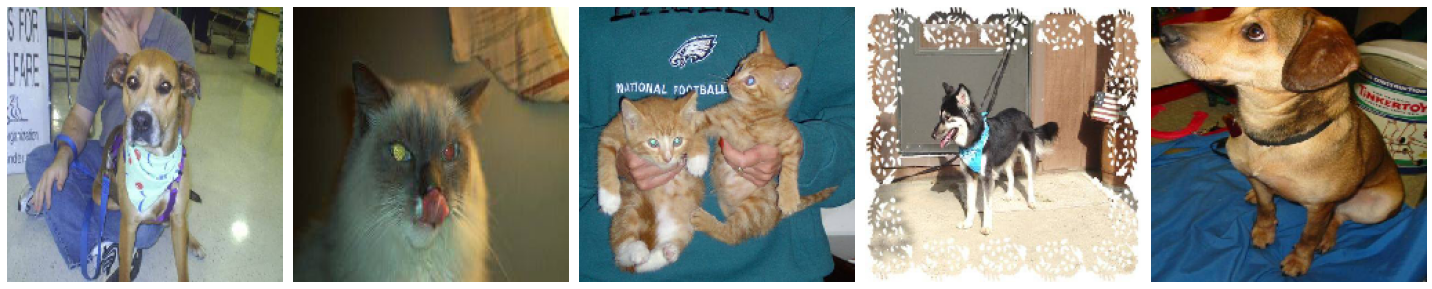

In [20]:
plotImage(sample_training_images[:5])

In [23]:
model = keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(1)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

In [25]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // bs,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // bs
)

Epoch 1/5
15/15 [==============================] - 91s 6s/step - loss: 1.1113 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5112
Epoch 2/5
15/15 [==============================] - 84s 6s/step - loss: 0.6923 - accuracy: 0.4968 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/5
15/15 [==============================] - 84s 6s/step - loss: 0.6885 - accuracy: 0.5187 - val_loss: 0.6895 - val_accuracy: 0.5067
Epoch 4/5
15/15 [==============================] - 83s 6s/step - loss: 0.6738 - accuracy: 0.5134 - val_loss: 0.6962 - val_accuracy: 0.6004
Epoch 5/5
15/15 [==============================] - 87s 6s/step - loss: 0.6285 - accuracy: 0.6058 - val_loss: 0.6447 - val_accuracy: 0.5871
